<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/Predicting_Cardiovascular_Disorder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting possibility of cardiovascular disorder

## Imports

In [87]:
# imports

# learning and logistics
import torch
import torch.nn as nn
import torch.nn.functional as F

# for number-crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

# for dataset management
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Getting and understaning the data
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
    * Value 1: typical angina
    * Value 2: atypical angina
    * Value 3: non-anginal pain
    * Value 4: asymptomatic
4. restbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    * Value 1: upsloping
    * Value 2: flat
    * Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
    * Value 0: < 50% diameter narrowing
    * Value 1: > 50% diameter narrowing
    * (in any major vessel: attributes 59 through 68 are vessels)



In [88]:
# obtaining data from ics
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# reading and adding header
df = pd.read_csv(url,sep=',')
df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# displaying sample data
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


## Preprocessing and analysing the data

In [89]:
# The dataset turned out to have missing values - '?' in 'ca' and 'thal',
# therefore we are marking them and dropping in preprocessing
missing_ca = df['ca'] == '?'
df.loc[missing_ca, 'ca'] = -1

missing_thal = df['thal'] == '?'
df.loc[missing_thal, 'thal'] = -1

df['ca'] = df['ca'].astype('float64')
df['thal'] = df['thal'].astype('float64')

df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.652318,4.692053,0.940397
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,0.951469,1.990310,1.229384
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


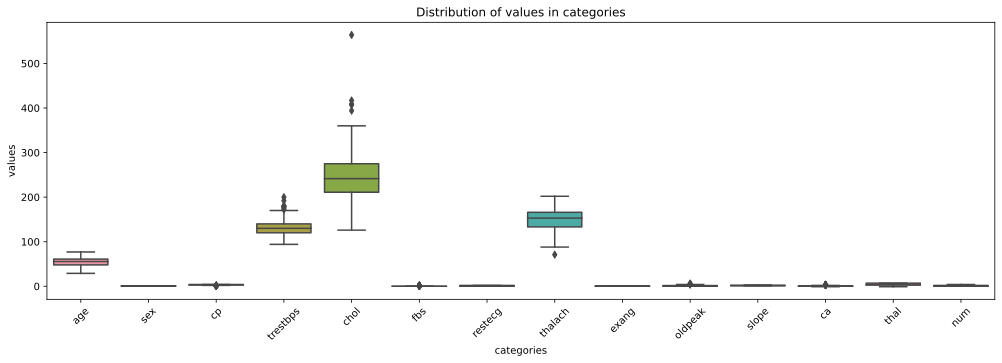

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,54.471186,0.677966,3.166102,131.705085,246.325424,0.142373,0.989831,149.562712,0.328814,1.049492,1.596610,0.681356,4.718644,0.952542
std,9.037621,0.468050,0.959842,17.779578,48.778507,0.350026,0.994833,23.011428,0.470580,1.167382,0.614442,0.940487,1.939254,1.236265
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.500000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,417.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [90]:
# display distribution
fig,ax = plt.subplots(1,figsize=(17,5))
ax = sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Distribution of values in categories')
ax.set_ylabel('values')
ax.set_xlabel('categories')
plt.show()

# drop outliers
df = df[ df['chol'] < 500 ]
df = df[ df['ca'] > -1 ]
df = df[ df['thal'] > -1 ]

df.describe()

## Spliting labels into binary problem + normalization

Patient with label 0 and 1 is concidered healthy, where patients with labels 2-4 are concidered to have higher probability of cardiovascural disorders

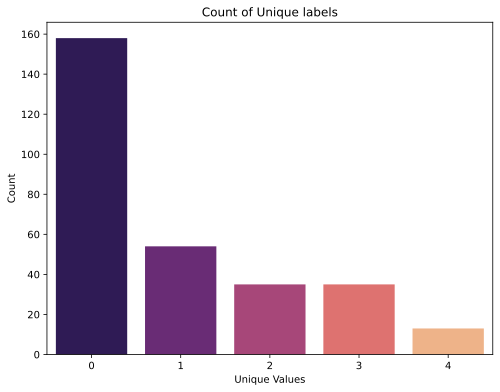

In [91]:
# plot distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='num', palette='magma')

# Add labels and a title
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique labels')

# Show the plot
plt.show()

In [92]:
# find the columns we want to normalize (all except labels)
scaler = MinMaxScaler()

# Define the columns to be normalized (exclude 'nums')
columns_to_normalize = df.columns[:-1]  # Exclude the last column 'nums'

# Fit and transform the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [93]:
# binarize the problem
df['boolNum'] = 0
df['boolNum'][df['num']>0] = 1
df.head()

<ipython-input-93-c861e69e45ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['boolNum'][df['num']>0] = 1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,boolNum
0,0.791667,1.0,1.000000,0.622642,0.549828,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,0.0,2,1
1,0.791667,1.0,1.000000,0.245283,0.353952,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.0,1,1
2,0.166667,1.0,0.666667,0.339623,0.426117,0.0,0.0,0.885496,0.0,0.564516,1.0,0.000000,0.0,0,0
3,0.250000,0.0,0.333333,0.339623,0.268041,0.0,1.0,0.770992,0.0,0.225806,0.0,0.000000,0.0,0,0
4,0.562500,1.0,0.333333,0.245283,0.378007,0.0,0.0,0.816794,0.0,0.129032,0.0,0.000000,0.0,0,0


## Creating train-test sets

In [94]:
dataT  = torch.tensor( df[columns_to_normalize].values ).float()
labelsT = torch.tensor( df['boolNum'].values ).long()[:,None]

# dividing data into 90/10 sets (train, dev, test)
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size=0.9)

# converting data into TensorDatasets and then DataLoaders
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=8,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Creating DL Model

In [95]:
# function to create model, loss function and optimizer
def create_model():

    class CardioNet(nn.Module):

        # class initialisation
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(13,64)

            # hidden layer
            self.fc1 = nn.Linear(64, 16)

            # output layer
            self.output = nn.Linear(16, 1)

        # forward pass
        def forward(self, x):

            x = F.leaky_relu( self.input(x) )

            x = F.leaky_relu( self.fc1(x) )

            return self.output(x)

    # model instance
    net = CardioNet()

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [96]:
def training_loop():

    # number of epochs
    numepochs = 100

    # create a new model
    net, lossfun, optimizer = create_model()


    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        net.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y.float())

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

        # average accuracy and losses over batches
        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    return trainAcc, testAcc, losses, net

In [99]:
# running the model once as a test
trainAcc, testAcc, losses, net = training_loop()

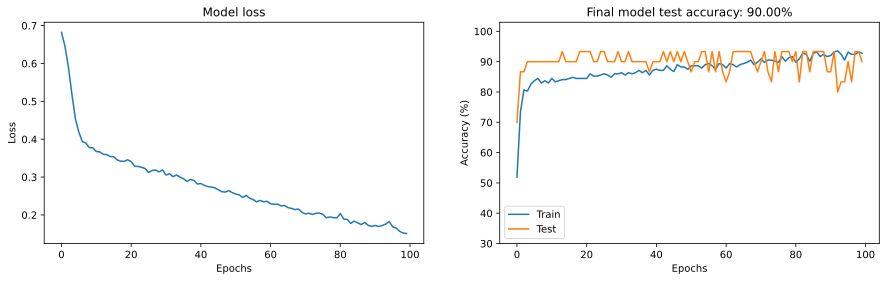

In [98]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

# plotting losses
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

# plotting accuracy
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([30,103])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()